In [402]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import seaborn as sns
sns.set()

from dotenv import load_dotenv
from binance.client import Client
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # for evaluating model performance

In [403]:
df = pd.read_json('/Users/goldenhello/Desktop/Quant/Matic_Strategy/data_1.json')
df.shape

(86381, 28)

In [404]:
# Assuming 'Processed Difference' is the dependent variable
X = df.drop('Processed Difference', axis=1)  # Independent variables
y = df['Processed Difference']  # Dependent variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 40% data as test set

In [405]:
X_train = X_train.drop('Open time', axis=1)
X_test = X_test.drop('Open time', axis=1)

In [406]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 1,
                max_depth = 8, alpha = 10, n_estimators = 18)

In [407]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [408]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 1.822148


In [409]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual Values': y_test,
    'Predicted Values': y_pred
})

# Optionally, reset index to make it cleaner
results_df.reset_index(drop=True, inplace=True)

In [410]:
results_df.head(5)

,Actual Values,Predicted Values
0,1,1.540579
1,1,2.064369
2,0,1.335754
3,1,2.944290
4,2,3.066344


                         Feature  Importance
6               Number of trades    0.106842
13                  60 Period MA    0.063066
2                            Low    0.060281
14                  14 Period MA    0.057847
15                  Close_prev_1    0.054259
12                 300 Period MA    0.047626
19                  Close_prev_5    0.045007
3                          Close    0.041390
1                           High    0.040322
24                 Close_prev_10    0.040313
25                       RSI_300    0.040271
22                  Close_prev_8    0.038982
16                  Close_prev_2    0.038430
20                  Close_prev_6    0.036550
23                  Close_prev_9    0.035191
17                  Close_prev_3    0.032329
18                  Close_prev_4    0.029585
21                  Close_prev_7    0.029016
5             Quote asset volume    0.024976
8   Taker buy quote asset volume    0.023081
11    Conditional Cumulative Sum    0.022167
0         

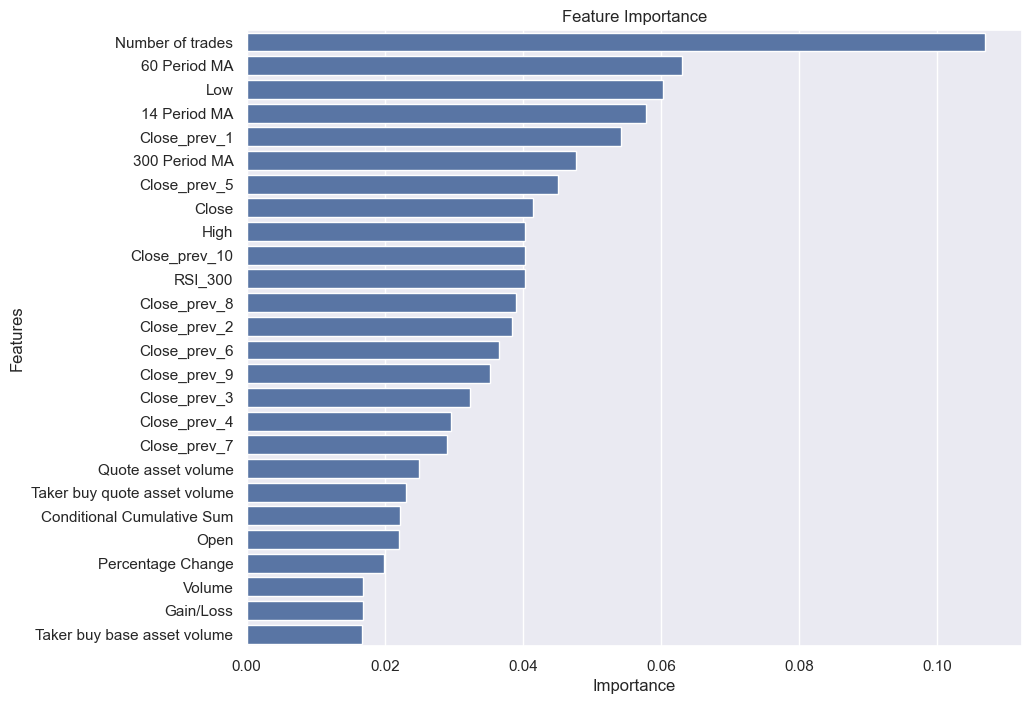

In [411]:
# Assuming 'rf' is your trained RandomForest model
feature_importances = xgb_model.feature_importances_

# Assuming you have a DataFrame 'X_train' from which you can get feature names
features = X_train.columns

# Create a DataFrame to hold feature names and their corresponding importance
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importances_df)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [412]:
# Assuming y_pred are your predictions and y_test are the actual values
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)
print("Explained Variance Score:", explained_variance)

MSE: 3.3202245460650666
RMSE: 1.8221483326186885
MAE: 1.4209146750807207
R-squared: 0.11881230746091254
Explained Variance Score: 0.1188140026530149


/Users/goldenhello/Desktop/Quant/Matic_Strategy/myenv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [413]:
results_df.head(5)

,Actual Values,Predicted Values
0,1,1.540579
1,1,2.064369
2,0,1.335754
3,1,2.944290
4,2,3.066344


# Threshold here!

In [454]:
threshold = 6
error = 2
# Create a boolean mask where 'Score' > 10
mask = results_df['Predicted Values'] > threshold

# Apply the mask to create a new DataFrame
filtered_df = results_df[mask]

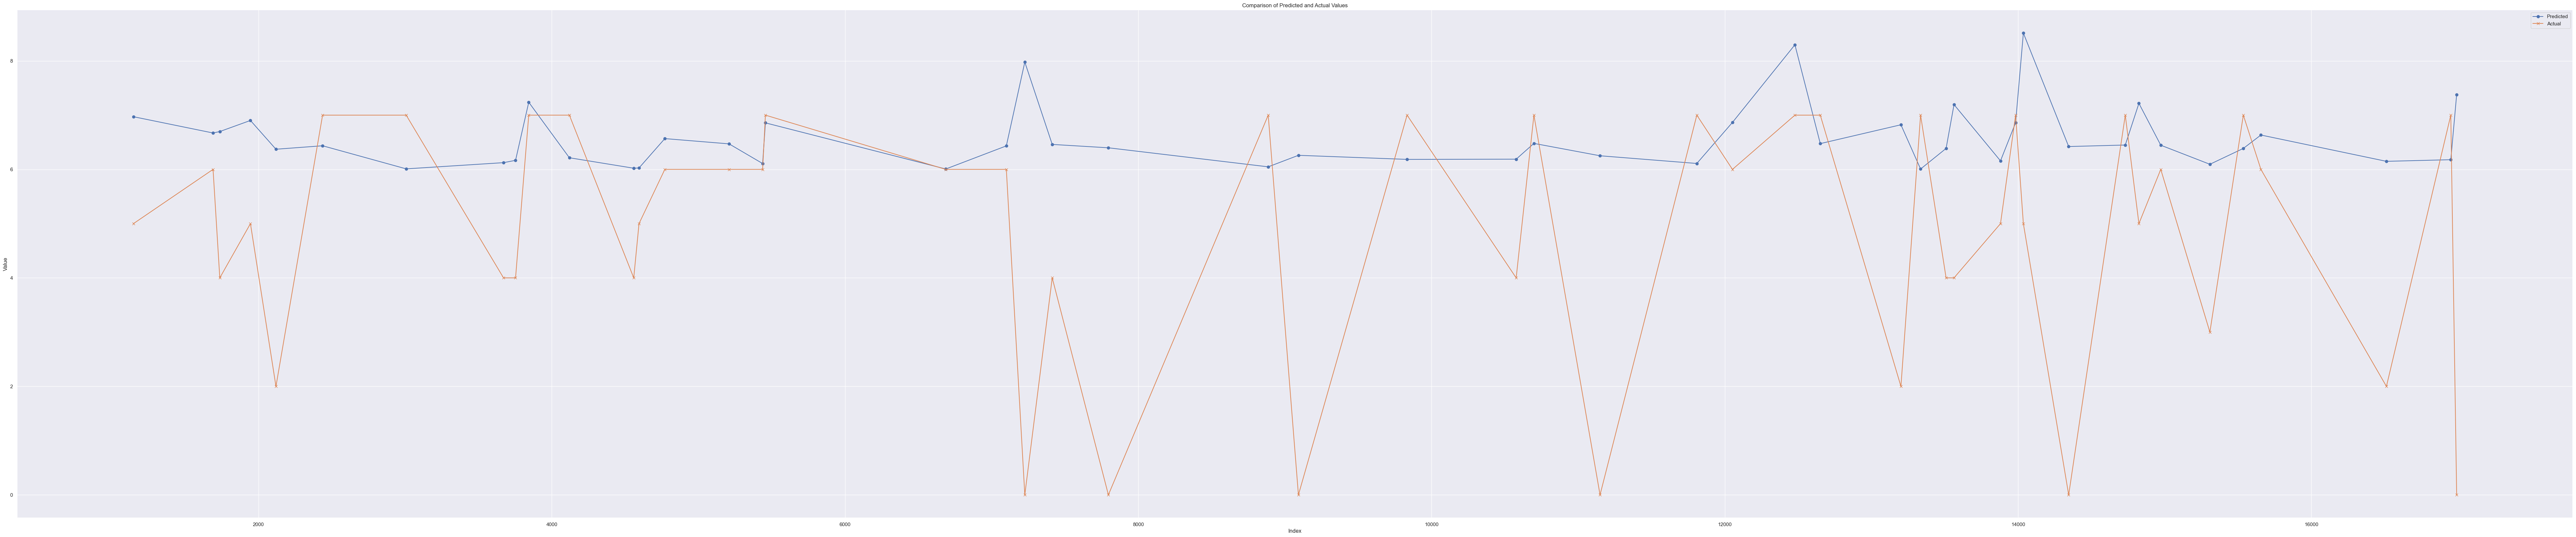

In [455]:
# Plotting
plt.figure(figsize=(100, 20))  # Set the figure size for better readability
plt.plot(filtered_df['Predicted Values'], label='Predicted', marker='o')  # Plot predicted values
plt.plot(filtered_df['Actual Values'], label='Actual', marker='x')  # Plot actual values

# Adding titles and labels
plt.title('Comparison of Predicted and Actual Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()  # Show legend to identify the lines

# Show the plot
plt.grid(True)  # Optional: Adds a grid for easier reading of values
plt.show()

In [456]:
# Count values above the threshold
count_above_threshold = (filtered_df['Actual Values'] >= threshold).sum()
total_rows = filtered_df['Actual Values'].count()


print("Number of values above", threshold, ":", count_above_threshold)
print("Number of predictions: ", total_rows)
print("Accuracy ", count_above_threshold/total_rows)

Number of values above 6 : 25
Number of predictions:  49
Accuracy  0.5102040816326531


In [457]:
df_future_val = pd.read_json('/Users/goldenhello/Desktop/Quant/Matic_Strategy/data_futures.json')

In [458]:
df_future_val.columns

Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore', 'Gain/Loss',
       'Percentage Change', 'Conditional Cumulative Sum', '300 Period MA',
       '60 Period MA', '14 Period MA', 'Close_prev_1', 'Close_prev_2',
       'Close_prev_3', 'Close_prev_4', 'Close_prev_5', 'Close_prev_6',
       'Close_prev_7', 'Close_prev_8', 'Close_prev_9', 'Close_prev_10',
       'Close_future_1', 'Close_future_2', 'Close_future_3', 'Close_future_4',
       'Close_future_5', 'Close_future_6', 'Close_future_7', 'Close_future_8',
       'Close_future_9', 'Close_future_10', 'RSI_300', 'Processed Difference'],
      dtype='object')

In [459]:
# List of columns to consider for the minimum value
columns_to_consider = ['Close_future_1', 'Close_future_2', 'Close_future_3', 'Close_future_4',
       'Close_future_5', 'Close_future_6', 'Close_future_7', 'Close_future_8',
       'Close_future_9', 'Close_future_10']

df_future_val['Lowest Min'] = df_future_val[columns_to_consider].min(axis=1)

df_future_val['Stop Loss_Min'] = df_future_val['Close'] - df_future_val['Lowest Min']


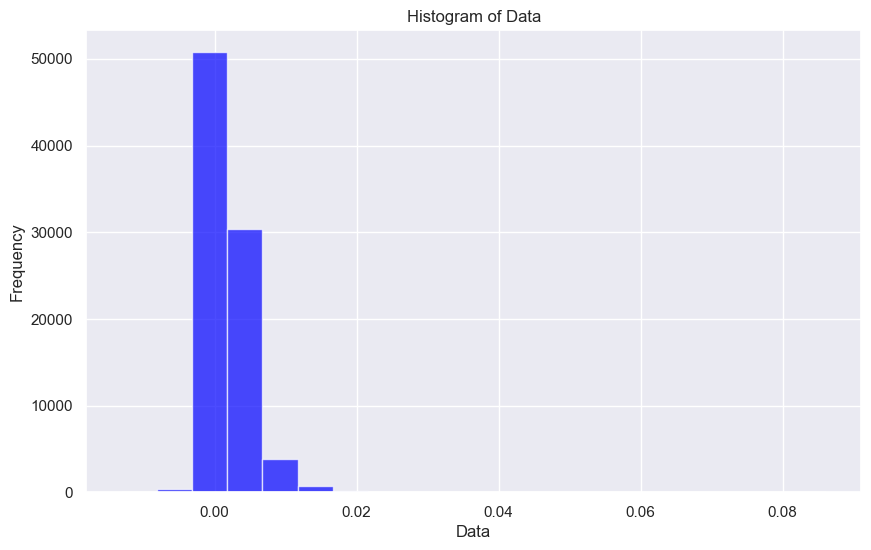

Mean of the data: 0.002005944444444444
Standard deviation of the data: 0.0031413890520919437
Two standard deviations above the mean: 0.008288722548628332


In [460]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_future_val['Stop Loss_Min'], bins=20, color='blue', alpha=0.7)  # Adjust bins or color as needed
plt.title('Histogram of Data')
plt.xlabel('Data')
plt.ylabel('Frequency')

# Show the plot
plt.grid(True)
plt.show()

# Calculate mean and standard deviation
mean_value = df_future_val['Stop Loss_Min'].mean()
std_dev = df_future_val['Stop Loss_Min'].std()

# Two standard deviations above the mean
two_std_above = mean_value + 2 * std_dev

print("Mean of the data:", mean_value)
print("Standard deviation of the data:", std_dev)
print("Two standard deviations above the mean:", two_std_above)

In [461]:
size=600
fee=0.001

filtered_df['Size']=size
filtered_df['fee']=filtered_df['Size']*fee
filtered_df['Position']=filtered_df['Size']-filtered_df['fee']
filtered_df['P/L'] = np.where((filtered_df['Actual Values'] >= (threshold-error)), ((filtered_df['Position'])*(1+((threshold-error)/1000))), filtered_df['Position']*(1-std_dev))
filtered_df['Net P/L']=filtered_df['P/L']-(size*fee)
filtered_df['Final P/L']=filtered_df['Net P/L']-filtered_df['Size']


/var/folders/tz/42t89gc96wlc7x7hvqz5gqnc0000gn/T/ipykernel_20433/3960815545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Size']=size
/var/folders/tz/42t89gc96wlc7x7hvqz5gqnc0000gn/T/ipykernel_20433/3960815545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['fee']=filtered_df['Size']*fee
/var/folders/tz/42t89gc96wlc7x7hvqz5gqnc0000gn/T/ipykernel_20433/3960815545.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [462]:
filtered_df.count()

Actual Values       49
Predicted Values    49
Size                49
fee                 49
Position            49
P/L                 49
Net P/L             49
Final P/L           49
dtype: int64

In [463]:
filtered_df['Final P/L'].sum()

15.876914021759376